# Image classification with Vision Transformer

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [43]:
from datetime import datetime
import pandas as pd
from tensorflow import keras
import tensorflow_addons as tfa

from dataloader import load_mnist
from data_augmentation import get_data_augmentation_layer
from plot import plot_patches
from vision_transformer import create_vit_classifier

## Prepare the data

In [33]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = load_mnist()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28, 1) - y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1) - y_test shape: (10000,)


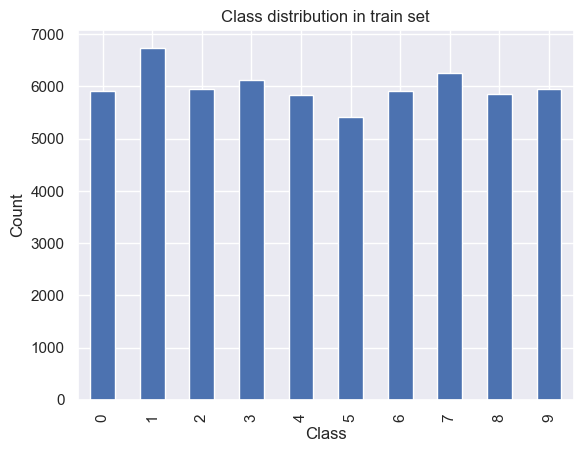

In [53]:
pd.Series(y_train).value_counts().sort_index().plot.bar(xlabel="Class", ylabel="Count",
                                                        title="Class distribution in train set");

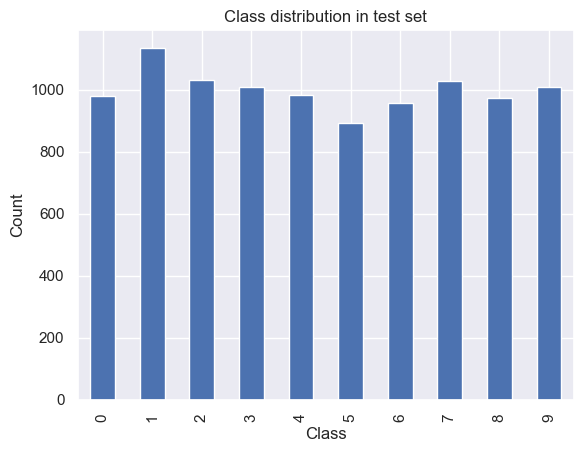

In [55]:
pd.Series(y_test).value_counts().sort_index().plot.bar(xlabel="Class", ylabel="Count",
                                                       title="Class distribution in test set");

## Configure the hyperparameters

In [37]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 28  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
n_transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


Let's display patches for a sample image

Image size: 28 X 28
Patch size: 6 X 6
Patches per image: 16
Elements per patch: 36


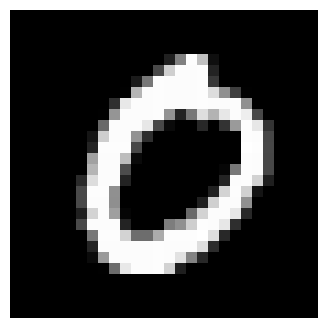

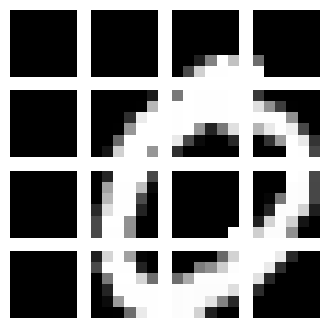

In [27]:
plot_patches(x_train=x_train, patch_size=patch_size, image_size=image_size)

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

## Compile, train, and evaluate the mode

In [28]:
vit_classifier = create_vit_classifier(input_shape=input_shape,
                                       num_classes=num_classes,
                                       image_size=image_size,
                                       patch_size=patch_size,
                                       num_patches=num_patches,
                                       projection_dim=projection_dim,
                                       n_transformer_layers=n_transformer_layers,
                                       num_heads=num_heads,
                                       transformer_units=transformer_units,
                                       mlp_head_units=mlp_head_units)

vit_classifier